In [13]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

from keras.callbacks import LearningRateScheduler, History
from keras.optimizers import Adam
from keras.models import Model
from keras.losses import categorical_crossentropy, hinge

import tensorflow as tf

In [33]:
tf.__version__

'1.3.0'

In [14]:
import sys
sys.path.append('/home/albert/github/DenseNet/')
import densenet
sys.path.append('/home/albert/github/tensorflow/src/')
import triplet
import evaluation
import data
import models

In [15]:
P_param = 4
K_param = 4

In [16]:
# dense = densenet.DenseNetImageNet121(weights='imagenet', include_top=False)

In [17]:
# np.save('/home/albert/github/tensorflow/src/DenseNetImageNet121-no-top.npy', dense.get_weights())

### Data

In [18]:
train_dict, train_files = data.get_data('train', keypoints=['Neck', 'RHip', 'LHip'])

In [19]:
len(train_files)

12355

preprocess True
keypoints ['Neck', 'RHip', 'LHip']
0.683449983597


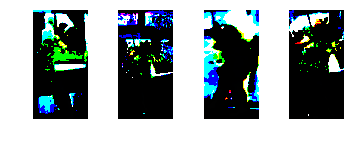

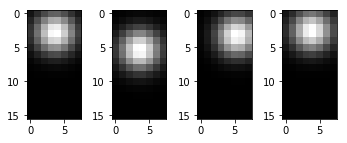

1.0
1.0
1.0
1.0


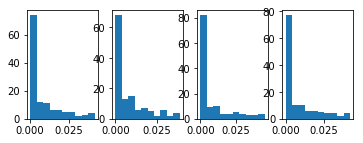

In [7]:
start = time.time()
batch = data.output_batch_generator(train_dict, P=P_param, K=K_param, preprocess=True,
                                    shape=(256,128), keypoints=['Neck', 'RHip', 'LHip'], 
                                    cam_output_dim=(16,8), rect=False).next()
print time.time() - start

plt.figure(figsize=(15,2))
for i in range(4):
    plt.subplot(1,10,i+1)
    plt.imshow(batch[0]['input_im'][i].astype(np.uint8))
    plt.axis('off')
plt.show()

import cv2
plt.figure(figsize=(15,2))
for i in range(4):
    plt.subplot(1,10,i+1)
    im = batch[1]['neck_cam_output'][i].squeeze()
    plt.imshow(im, cmap=plt.cm.gray)
    plt.axis('on')
plt.show()

plt.figure(figsize=(15,2))
for i in range(4):
    plt.subplot(1,10,i+1)
    im = batch[1]['neck_cam_output'][i].squeeze()
    print im.sum()
    plt.hist(im.flatten())
    plt.axis('on')
plt.show()

### Train Network

In [8]:
steps_per_epoch = 100

input_shape = (256,128)

preprocess = True

In [9]:
file_root = 'mergenet_neck_hip_svd_P4K4'
if os.path.exists('/home/albert/github/tensorflow/models/%s' % file_root) == False:
    os.system('mkdir /home/albert/github/tensorflow/models/%s' % file_root)

In [10]:
# First integer: number of epochs (e.g., 10)
# Second integer: era

epochs = 10

step_decay_cont_str = """
def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0003):
    drop = 0.5
    epochs_drop = 10.0
    t1 = 50.0
    if epoch + init_epoch < t1:
        lrate = init_lr
    else:
        lrate = init_lr * np.power(drop,  
               np.floor((epoch + init_epoch - t1 + epochs_drop)/(epochs_drop)))
    return lrate
"""

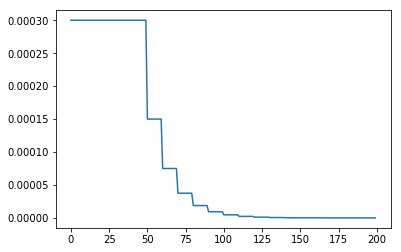

In [11]:
lr = []
for era in range(1,21):
    exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(step_decay_cont(j))
plt.plot(np.arange(200), lr)

In [26]:
mergenet = models.MergeNet(P_param, K_param, weights='imagenet', test=False, reduce_dim=False)

Weights for the model were loaded successfully


In [27]:
mergenet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_im (InputLayer)            (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_705 (Conv2D)              (None, 128, 64, 64)   9408        input_im[0][0]                   
____________________________________________________________________________________________________
batch_normalization_727 (BatchNo (None, 128, 64, 64)   256         conv2d_705[0][0]                 
____________________________________________________________________________________________________
activation_727 (Activation)      (None, 128, 64, 64)   0           batch_normalization_727[0][0]    
___________________________________________________________________________________________

In [29]:
mergenet.output

[<tf.Tensor 'final_output_9/BiasAdd:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'neck_cam_output_4/cam_output/Reshape_519:0' shape=(16, 8, 4) dtype=float32>,
 <tf.Tensor 'hip_cam_output_3/cam_output/Reshape_519:0' shape=(16, 8, 4) dtype=float32>]

In [30]:
output = mergenet.predict(batch[0]['input_im'])

In [32]:
print output[2].shape

(16, 8, 4)


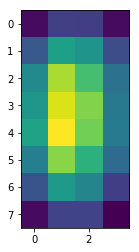

In [17]:
plt.imshow(output[2][2])

In [18]:
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.final_output_loss = []
        self.neck_cam_output_loss = []
        self.hip_cam_output_loss = []
        
    def on_epoch_end(self, epoch, logs={}):
#         print logs.keys()
        self.loss.append(logs['loss'])
        self.final_output_loss.append(logs['final_output_loss'])
        self.neck_cam_output_loss.append(logs['neck_cam_output_loss'])
        self.hip_cam_output_loss.append(logs['hip_cam_output_loss'])
    
    def on_train_end(self, logs={}):
        print self.loss, self.final_output_loss, self.neck_cam_output_loss, self.hip_cam_output_loss

In [19]:
model_json = mergenet.to_json()
with open("/home/albert/github/tensorflow/models/%s/%s.json" % (file_root, file_root), "w") as json_file:
    json_file.write(model_json)

In [20]:
# camnet.set_weights(np.load('/home/albert/github/tensorflow/models/spn_neck_svd_P6K4/spn_neck_svd_P6K4_1000.npy'))

In [12]:
train_score = {}
hist = {'loss' : [], 'final_output_loss' : [], 'neck_cam_output_loss' : [], 'hip_cam_output_loss' : []}
history = History()
loss = LossHistory()

NameError: name 'LossHistory' is not defined

In [22]:
for era in range(1,16):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    mergenet.fit_generator(data.output_batch_generator(train_dict, P=P_param, K=K_param, preprocess=True,
                                    shape=(256,128), keypoints=['Neck', 'RHip', 'LHip'], 
                                    cam_output_dim=(8,4), rect=False), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate, history, loss])
    
    file_name = file_root + '_' + str(iterations) + '.npy'
    np.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name), mergenet.get_weights())
    
    mergenet_test = models.load_model('/home/albert/github/tensorflow/pre/pre3/models/densenet_triplet/densenet_triplet.json',
                                    weights_file='/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name))
    train_score[iterations] = evaluation.get_score(mergenet_test, hist=history, preprocess=preprocess, cover=False)
    
    hist['loss'] += loss.loss
    hist['final_output_loss'] += loss.final_output_loss
    hist['neck_cam_output_loss'] += loss.neck_cam_output_loss
    hist['hip_cam_output_loss'] += loss.hip_cam_output_loss
    
    print iterations, train_score[iterations]

preprocess True
keypoints ['Neck', 'RHip', 'LHip']
Epoch 1/10
100/100 [==============================] - 243s - loss: 859.1470 - final_output_loss: 371.6030 - neck_cam_output_loss: 16.5098 - hip_cam_output_loss: 13.9328   
Epoch 2/10
100/100 [==============================] - 233s - loss: 795.8087 - final_output_loss: 314.5565 - neck_cam_output_loss: 16.3257 - hip_cam_output_loss: 13.7233   
Epoch 3/10
100/100 [==============================] - 233s - loss: 763.2225 - final_output_loss: 287.8917 - neck_cam_output_loss: 16.1120 - hip_cam_output_loss: 13.5667   
Epoch 4/10
100/100 [==============================] - 232s - loss: 719.3849 - final_output_loss: 252.2835 - neck_cam_output_loss: 15.8058 - hip_cam_output_loss: 13.3583   
Epoch 5/10
100/100 [==============================] - 232s - loss: 654.2608 - final_output_loss: 198.6466 - neck_cam_output_loss: 15.4182 - hip_cam_output_loss: 13.0279   
Epoch 6/10
100/100 [==============================] - 233s - loss: 604.0538 - final_outpu

AttributeError: 'LossHistory' object has no attribute 'neck_output_loss'

In [ ]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_hist.npz' % (file_root, file_root), hist)
np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (file_root, file_root), train_score)

In [27]:
file_name = file_root + '_' + str(1000) + '.npy'
np.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name), mergenet.get_weights())

### Evaluation

In [ ]:
evaluation.plot_rank('densenet_cam', ylim_0=0.0)

In [ ]:
evaluation.plot_loss('densenet_cam')

In [ ]:
evaluation.plot_rank('densenet_triplet_front', ylim_0=0.0)

In [11]:
file_root = 'mergenet_svd_P4K4'

for it in range(1000,2000,1000):
    # file_root = 'densenet_triplet_block_neck_on'
    file_name = file_root + '_' + str(it) + '.npy'
    camnet_test = models.MergeNet(1, 1, weights=None, test=True, keypoints=['neck'])
    camnet_test.set_weights(np.load('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name)))
    s = evaluation.get_score(camnet_test, hist=None, preprocess=preprocess, cover=False)
    print s

1000 24.3258399963
2000 48.0413758755
3000 71.7509448528
4000 95.385892868
5000 119.045758963
6000 142.725837946
7000 166.410779953
8000 190.180305004
9000 213.848989964
10000 237.513653994
11000 261.182407856
12000 284.865239859
13000 308.526726007
14000 332.18036294
15000 355.850869894
16000 379.510458946
17000 403.201186895
18000 426.868433952
19000 450.522295952
1000 23.8779990673
2000 47.5593371391
3000 71.210860014
{'mAP': 0.13636593963879334, 'rank': [0.27434679334916867, 0.5, 0.7143705463182898], 'loss': []}
